In this notebook, we explore the effect of freezing CLIP models.

### Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dataclasses
import pathlib
import sys

import clip.model
import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.utils.data

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src import utils
from src.pretrain.datasets.vision import cifar10, imagenette, svhn
from src.pretrain.models.vision import laion_clip, msft_beit, openai_clip
from src.pretrain.probes import fc_probe

### Load network

In [3]:
torch.manual_seed(0)

dataset_cfg = cifar10.CIFAR10()
embedder_cfg = openai_clip.OpenaiClipConfig(id="openai/ViT-B/16")

embedder = embedder_cfg.get_model().float()
model = (
    fc_probe.FCProbeConfig(n_layers=1, n_classes=10)
    .get_fc_probe(embedder)
    .cuda()
)

### Compute fraction of params frozen

In [4]:
layers = model.embedder.get_layers_for_freezing()
len(layers)

18

In [7]:
assert sum(utils.count_params(l) for l in layers) == utils.count_params(
    model.embedder
)

In [5]:
param_counts = np.array([utils.count_params(layer) for layer in layers])
param_counts

array([    768,  151296,  589824,    1536, 7087872, 7087872, 7087872,
       7087872, 7087872, 7087872, 7087872, 7087872, 7087872, 7087872,
       7087872, 7087872,    1536,  393216])

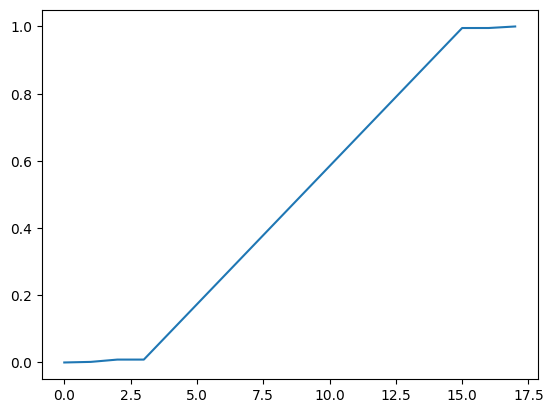

In [6]:
plt.plot(param_counts.cumsum() / param_counts.sum())